In [2]:
import tensorflow as tf
import skimage.io
import skimage.color
import numpy as np
from pprint import pprint

In [3]:
import read_cifar10 as cf10

#@read_data.restartable
def cifar10_dataset_generator(dataset_name, batch_size, restrict_size=1000):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1  # -1 for entire dataset
    
    X_all_unrestricted, y_all = (cf10.load_training_data() if dataset_name == 'train'
                                 else cf10.load_test_data())
    
    actual_restrict_size = restrict_size if dataset_name == 'train' else int(1e10)
    X_all = X_all_unrestricted[:actual_restrict_size]
    data_len = X_all.shape[0]
    batch_size = batch_size if batch_size > 0 else data_len
    
    X_all_padded = np.concatenate([X_all, X_all[:batch_size]], axis=0)
    y_all_padded = np.concatenate([y_all, y_all[:batch_size]], axis=0)
    
    for slice_i in range(math.ceil(data_len / batch_size)):
        idx = slice_i * batch_size
        #X_batch = X_all_padded[idx:idx + batch_size]
        X_batch = X_all_padded[idx:idx + batch_size]*255  # bugfix: thanks Zezhou Sun!
        y_batch = np.ravel(y_all_padded[idx:idx + batch_size])
        yield X_batch.astype(np.uint8), y_batch.astype(np.uint8)

cifar10_dataset_generators = {
    'train': cifar10_dataset_generator('train', 1000),
    'test': cifar10_dataset_generator('test', -1)
}


In [4]:
#Load cifar-10 data


cf10_tr=cf10.load_training_data()
cf10_tr_img=cf10_tr[0]
cf10_tr_label = cf10_tr[1]
print(cf10_tr_img.shape)

cf10_test=cf10.load_test_data()
cf10_test_img=cf10_test[0]
cf10_test_label = cf10_test[1]
print(cf10_test_img.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
cf10_test_img_gray=(cf10_test_img[:,:,:,0]+cf10_test_img[:,:,:,1]+cf10_test_img[:,:,:,2])/3.
cf10_tr_img_gray=(cf10_tr_img[:,:,:,0]+cf10_tr_img[:,:,:,1]+cf10_tr_img[:,:,:,2])/3.
cf10_tr_vec=np.zeros((50000,1024))
cf10_test_vec=np.zeros((10000,1024))

Before running the next code add a folder named "cifar10_jpg"

In [6]:
#Calculate the metrics for jpg


mse_jpg=np.zeros((10000,1))
psnr_jpg=np.zeros((10000,1))
#Save cifar test images
for k in range(10000):
    img_gray=(255*cf10_test_img_gray[k,:,:]).astype(np.uint8)
    skimage.io.imsave('../cifar10_jpg/'+str(k)+'.jpg',img_gray)
    
    img_vec = img_gray.reshape([1,-1])
    cf10_test_vec[k,:]=img_vec
    img_recons = skimage.io.imread('../cifar10_jpg/'+str(k)+'.jpg')
    #print(k)
    #print(img_recons)#-img_gray)
    #print(img_gray)
    #print(img_recons.astype(int)-img_gray.astype(int))
    #print(((img_recons.astype(float)-img_gray.astype(float))/255.)*255.)
    mse=(((img_recons.astype(float)-img_gray.astype(float))/255.)**2).mean()
    mse_jpg[k]=mse
    psnr_jpg[k]=10.*np.log10(1./mse)

print('test is done')
for k in range(50000):
    img_gray=(255*cf10_tr_img_gray[k,:,:]).astype(np.uint8)
    img_vec = img_gray.reshape([1,-1])
    cf10_tr_vec[k,:]=img_vec
    
print('train is done')



test is done
train is done


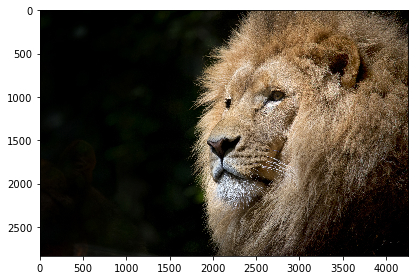

3


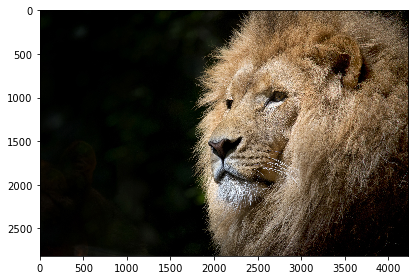

In [7]:
# Create test image and algoirthm to divide it into blocks and then reconstructing at back

import skimage.io

def block2img(img_blocks,img_size):
    
    row,col = img_size
    img=np.zeros((row,col,3)).astype(np.float32)
    n,k,l,c=img_blocks.shape
                 
    for i in range(0,int(row/k)):
        for j in range(0,int(col/k)):
            img[i*k:(i+1)*k,j*l:(j+1)*l,:]=img_blocks[int(i*col/k+j),:,:,:]
    return img

lion = skimage.io.imread('../test_img/lion.jpg')
lion[:2816,:4224,:]
skimage.io.imshow(lion)
skimage.io.show()

lion = lion.astype(np.float32)
row,col,color = lion.shape
lion_32=np.zeros((int(row*col/1024),32,32,3)).astype(np.float32)

print(row%8)
count =0
for i in range(0,row-row%32,32):
    for j in range(0,col-col%32,32):
        lion_32[count,:,:,:]=lion[i:i+32,j:j+32,:]
        count = count +1
lion_32=lion_32/255.

lion_recon=block2img(lion_32,(2816,4224))
lion_recon = (lion_recon*255.).astype(np.uint8)
skimage.io.imshow(lion_recon)
skimage.io.show()
skimage.io.imsave('../test_img/lion_recon.tiff',lion_recon)
        
        

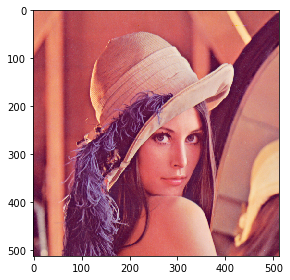

0


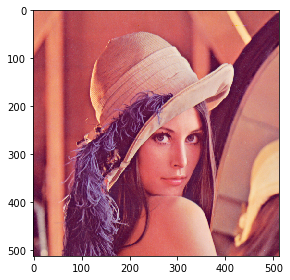

In [8]:
# Same as above for another image. I will make it more modular :)

import skimage.io

def block2img(img_blocks,img_size):
    
    row,col = img_size
    img=np.zeros((row,col,3)).astype(np.float32)
    n,k,l,c=img_blocks.shape
                 
    for i in range(0,int(row/k)):
        for j in range(0,int(col/k)):
            img[i*k:(i+1)*k,j*l:(j+1)*l,:]=img_blocks[int(i*col/k+j),:,:,:]
    return img

lena = skimage.io.imread('../test_img/lena512color.tiff')
skimage.io.imshow(lena)
skimage.io.show()

lena = lena.astype(np.float32)
row,col,color = lena.shape
lena_8x8=np.zeros((int(row*col/1024),32,32,3)).astype(np.float32)

print(row%8)
count =0
for i in range(0,row-row%32,32):
    for j in range(0,col-col%32,32):
        lena_8x8[count,:,:,:]=lena[i:i+32,j:j+32,:]
        count = count +1
lena_8x8=lena_8x8/255.

lena_recon=block2img(lena_8x8,(512,512))
lena_recon = (lena_recon*255.).astype(np.uint8)
skimage.io.imshow(lena_recon)
skimage.io.show()
skimage.io.imsave('../test_img/lena512color_recon.tiff',lena_recon)
        
        

In [9]:
def convert2uint8(img):
    img[img>255]=255
    img[img<0]=0
    return img.astype(np.uint8)

# Part-2 - CNN

In [9]:
x_tr = cf10_tr_img.astype(np.float32)#*255.
x_test = cf10_test_img.astype(np.float32)#*255.
x_test=x_test[:200,:,:,:]
print(x_tr.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(200, 32, 32, 3)


In [10]:
def cnn_autoencoder(x_,kernels1=[5,7],kernels2=[7,5],filters1=[16,128],filters2=[128,3],pool_size=[1,2]):
    out_=x_
    for k in range(len(kernels1)):
        conv = tf.layers.conv2d(inputs=out_,
                                filters=filters1[k],
                                kernel_size=[kernels1[k],kernels1[k]],
                                padding="same",
                                activation=tf.nn.relu,
                                name='conv'+str(k))
        pool_now=pool_size[k]
        if(pool_now==1):
            out_=conv
        else:
            out_ = tf.layers.max_pooling2d(inputs=conv, 
                                           pool_size=[pool_now,pool_now], 
                                           strides=pool_now,
                                           name = 'pool'+str(k))
        
        out_quant=tf.round(out_*255.)/255.

    for k in range(len(kernels2)):
        with tf.variable_scope("deconv") as var_scope:
            pool_now=pool_size[-1-k]
            if(pool_now==1):
                x_up=out_
                out_ = tf.layers.conv2d(inputs=x_up,
                                        filters=filters2[k],
                                        kernel_size=[kernels2[k],kernels2[k]],
                                        padding="same",
                                        activation=tf.nn.relu,
                                        name='deconv'+str(k))
                var_scope.reuse_variables() 
                x_quant_up=out_quant
                out_quant = tf.layers.conv2d(inputs=x_quant_up,
                                            filters=filters2[k],
                                            kernel_size=[kernels2[k],kernels2[k]],
                                            padding="same",
                                            activation=tf.nn.relu,
                                            name='deconv'+str(k))
            else:
                sh = out_.get_shape().as_list()
                x_up=tf.image.resize_images(out_,[sh[1]*pool_now,sh[2]*pool_now])
                out_ = tf.layers.conv2d(inputs=x_up,
                                        filters=filters2[k],
                                        kernel_size=[kernels2[k],kernels2[k]],
                                        padding="same",
                                        activation=tf.nn.relu,
                                        name='deconv'+str(k))
                var_scope.reuse_variables() 
                x_quant_up=tf.image.resize_images(out_quant,[sh[1]*pool_now,sh[2]*pool_now])
                out_quant = tf.layers.conv2d(inputs=x_quant_up,
                                            filters=filters2[k],
                                            kernel_size=[kernels2[k],kernels2[k]],
                                            padding="same",
                                            activation=tf.nn.relu,
                                            name='deconv'+str(k))


    return out_,out_quant


In [11]:
#Working
def apply_classification_loss_mse(kernels1=[5,7],kernels2=[7,5],
                                 filters1=[16,128],filters2=[128,3],
                                pool_size=[2,2],learning_rate=1.):
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):  # use gpu:0 if on GPU
            x_ = tf.placeholder(tf.float32, [None, 32, 32, 3])
            (x_out,x_out_quant)=cnn_autoencoder(x_,pool_size=pool_size,kernels1=kernels1,filters1=filters1,
                                kernels2=kernels2,filters2=filters2)

            #y_dict = dict(labels=y_, logits=y_logits)
            #losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            #cross_entropy_loss = tf.reduce_mean(losses)
            mse_loss1=tf.reduce_mean(tf.subtract(x_,x_out)**2)
            #a=tf.pad(tf.subtract(x_,x_out),[[0,0],[16,16],[16,16],[0,0]],'CONSTANT')

            #mse_loss1=tf.reduce_mean(tf.nn.conv2d(a,h3,strides=[1,1,1,1],padding="VALID")**2)
            mse_loss2=tf.reduce_mean(tf.subtract(x_,x_out_quant)**2)
            trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = trainer.minimize(mse_loss1)

            #y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            #correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    model_dict = {'graph': g, 'inputs': x_,'outputs':x_out_quant, 'train_op': train_op, 'loss1': mse_loss1,'loss2': mse_loss2}
    
    return model_dict

In [12]:
#In progress
def apply_classification_loss_ssim(kernels1=[5,7],kernels2=[7,5],
                                 filters1=[16,128],filters2=[128,3],
                                pool_size=[2,2],learning_rate=1.):
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):  # use gpu:0 if on GPU
            x_ = tf.placeholder(tf.float32, [None, 32, 32, 3])
            (x_out,x_out_quant)=cnn_autoencoder(x_,pool_size=pool_size,kernels1=kernels1,filters1=filters1,
                                kernels2=kernels2,filters2=filters2)

            #y_dict = dict(labels=y_, logits=y_logits)
            #losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            #cross_entropy_loss = tf.reduce_mean(losses)
            mse_loss1=tf.reduce_mean(tf.subtract(x_,x_out)**2)
            #a=tf.pad(tf.subtract(x_,x_out),[[0,0],[16,16],[16,16],[0,0]],'CONSTANT')

            #mse_loss1=tf.reduce_mean(tf.nn.conv2d(a,h3,strides=[1,1,1,1],padding="VALID")**2)
            mse_loss2=tf.reduce_mean(tf.subtract(x_,x_out_quant)**2)
            trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = trainer.minimize(mse_loss1)

            #y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            #correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    model_dict = {'graph': g, 'inputs': x_,'outputs':x_out_quant, 'train_op': train_op, 'loss1': mse_loss1,'loss2': mse_loss2}
    
    return model_dict

In [13]:
def train_model(model_dict, dataset_generators, train_every=100, test_every=200,learning_rate=1.,fname='cifar10_recon'):
    with model_dict['graph'].as_default(), tf.Session() as sess:
        saver=tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        
        ids=[i for i in range(100)]
        for iter_i in range(1000):
            batch_xs = x_tr[ids,:,:,:] 
            ids=[(ids[0]+100+i)%x_tr.shape[0] for i in range(100)]
            sess.run(model_dict['train_op'], feed_dict={model_dict['inputs']: batch_xs})
            
            # test trained model
            if iter_i % train_every == 0:
                tf_feed_dict = {model_dict['inputs']: batch_xs}
                loss_val = sess.run(model_dict['loss1'], feed_dict={model_dict['inputs']: batch_xs})
                print('iteration %d\t train mse: %.3E\t'%(iter_i,loss_val))
                if iter_i % test_every == 0:
                    #tf_feed_dict = {x_: x_test}
                    loss_val1 = sess.run(model_dict['loss1'], feed_dict={model_dict['inputs']: x_test})
                    loss_val2 = sess.run(model_dict['loss2'], feed_dict={model_dict['inputs']: x_test})
                    print('iteration %d\t TEST MSE: %.3E\t TEST MSE(Quantized): %.3E\t'%(iter_i,loss_val1,loss_val2))
                    
                    
                    lena_block=sess.run(model_dict['outputs'], 
                                       feed_dict={model_dict['inputs']:lena_8x8})
                    x_from_test=sess.run(model_dict['outputs'], 
                                         feed_dict={model_dict['inputs']:x_test[:5,:,:,:].reshape([-1,32,32,3])})
                    
                    lena_recon=block2img(lena_block,(512,512))
                    lena_recon = (lena_recon*255.).astype(np.uint8)
                    skimage.io.imsave('../test_img/lena_'+str(int(iter_i/test_every))+'.tiff',lena_recon)

                    for i in range(5):
                        img_recon=(255*x_from_test[i,:,:,:]).reshape([32,32,3]).astype(np.uint8)
                        skimage.io.imsave('../'+fname+'/test'+str(i)+'_'+str(int(iter_i/test_every))+'.tiff',img_recon)
                        
                    '''
                    print('Train')
                    print(np.round(x_from_tr*255).reshape([-1,3072]))
                    print(np.round((x_from_tr-batch_xs[:5,:])*255).reshape([-1,3072]))
                    '''
                    print('Test')
                    print(np.round(x_from_test*255).reshape([-1,3072]))
                    print(np.round((x_from_test-x_test[:5,:])*255).reshape([-1,3072]))
        '''           
        var_list=[]
        with tf.variable_scope('conv1',reuse=True):
            var_list.append ( tf.get_variable('kernel') )
        '''
        saver = tf.train.Saver()
        save_path = saver.save(sess, "/tmp/cnn_autoencoder")
        print("Model saved in file: %s" % save_path)
        return saver
                


The code at the below saves the reconstructed images in every 500 iterations. Cifart images are being saved to "cifar10_recon0" folder. You need to create that folder before running the code. It also saves the reconstructed version of Lena image into "test_img" folder.

In [14]:
tf.reset_default_graph()
model_dict=apply_classification_loss_mse(kernels1=[5,7,9],kernels2=[9,7,5],
                                     filters1=[16,64,128],filters2=[64,16,3],
                                     pool_size=[1,1,2],learning_rate=0.0001)
saver = train_model(model_dict, [], train_every=100, test_every=500,fname='cifar10_recon0')

iteration 0	 train mse: 1.786E-01	
iteration 0	 TEST MSE: 2.026E-01	 TEST MSE(Quantized): 2.026E-01	
Test
[[ 0.  4.  5. ...,  6.  0.  0.]
 [ 0.  7.  8. ...,  7.  0.  1.]
 [ 0.  6.  7. ...,  2.  0.  0.]
 [ 0.  5.  8. ...,  6.  0.  0.]
 [ 0.  3.  4. ...,  7.  0.  0.]]
[[-158. -108.  -44. ...,  -15.  -67. -110.]
 [-235. -228. -227. ..., -179. -200. -198.]
 [-158. -184. -215. ...,   -5.   -8.   -7.]
 [-155. -151. -141. ...,  -67.  -68.  -50.]
 [ -65.  -65.  -46. ..., -121. -156. -117.]]
iteration 100	 train mse: 8.982E-03	
iteration 200	 train mse: 5.114E-03	
iteration 300	 train mse: 4.080E-03	
iteration 400	 train mse: 3.346E-03	
iteration 500	 train mse: 3.038E-03	
iteration 500	 TEST MSE: 2.704E-03	 TEST MSE(Quantized): 2.705E-03	
Test
[[ 110.   99.   57. ...,   66.   90.  108.]
 [ 211.  200.  199. ...,  158.  165.  173.]
 [ 165.  165.  172. ...,   17.   22.   24.]
 [ 146.  142.  154. ...,   74.   76.   77.]
 [  61.   62.   53. ...,  125.  134.  127.]]
[[-48. -13.   8. ...,  45.  23.  

In [15]:
#Load the weights and try them with another image

with model_dict['graph'].as_default(), tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    '''
    var_list=[]
    with tf.variable_scope('conv1',reuse=True):
        var_list.append ( tf.get_variable('kernel') )
    '''
    saver = tf.train.Saver()
    saver.restore(sess, "/tmp/cnn_autoencoder")
    print("Model loaded")
    
    img_block = np.zeros(lion_32.shape)
    
    n= np.floor(lion_32.shape[0]/2000).astype(int)
    print(n)
    for i in range(0,n):
        print(str(i+1)+'th slice')
        img_block[i*2000:(i+1)*2000,:,:,:]=sess.run(model_dict['outputs'], 
                                    feed_dict={model_dict['inputs']:lion_32[i*2000:(i+1)*2000,:,:,:]})
    img_block[n*2000:,:,:,:]=sess.run(model_dict['outputs'], 
                                    feed_dict={model_dict['inputs']:lion_32[n*2000:,:,:,:]})
        
    img_recon=block2img(img_block,(2816,4224))
    img_recon = (img_recon*255.).astype(np.uint8)
    skimage.io.imsave('../test_img/lion_recon.tiff',img_recon)

'''
config = tf.ConfigProto(allow_soft_placement = True)
with model_dict['graph'].as_default(), tf.Session(config=config) as sess:
    # Restore variables from disk.
    #sess.run(tf.global_variables_initializer())
    new_saver = tf.train.import_meta_graph('/tmp/ali.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model restored.")
    all_vars = tf.get_collection('vars')
    for v in all_vars:
        v_ = sess.run(v)
        print(v_)
    x_from_test=sess.run(model_dict['outputs'], 
                                feed_dict={model_dict['inputs']:x_test[:5,:,:,:].reshape([-1,32,32,3])})
    print(x_from_test)
'''

Model loaded
5
1th slice
2th slice
3th slice
4th slice
5th slice


'\nconfig = tf.ConfigProto(allow_soft_placement = True)\nwith model_dict[\'graph\'].as_default(), tf.Session(config=config) as sess:\n    # Restore variables from disk.\n    #sess.run(tf.global_variables_initializer())\n    new_saver = tf.train.import_meta_graph(\'/tmp/ali.meta\')\n    new_saver.restore(sess, tf.train.latest_checkpoint(\'./\'))\n    print("Model restored.")\n    all_vars = tf.get_collection(\'vars\')\n    for v in all_vars:\n        v_ = sess.run(v)\n        print(v_)\n    x_from_test=sess.run(model_dict[\'outputs\'], \n                                feed_dict={model_dict[\'inputs\']:x_test[:5,:,:,:].reshape([-1,32,32,3])})\n    print(x_from_test)\n'